# Comparison of Two Time Series of Maps 1.0
*This notebook implements the framework from the article “Foundational concepts and equations to compare two time series of maps” to quantify and visualize agreement and change between two temporal map series. Using toy data, it defines modular Python functions to compute presence‐agreement components, gains and losses, and full‐extent change metrics, and produces clear visualizations and exportable results for reproducible analysis.*

## Table of Contents  
1. [Environment Setup](#environment-setup)
2. [Toy Data Input Format](#data-preparation)
3. [Presence Agreement Components (Eqs 1–12)](#presence-agreement)
4. [Change Components: Gains & Losses (Eqs 13–40)](#change-components)
5. [Full-Extent Change Metrics (Eqs 29–40, 41–52)](#full-extent)
6. [Visualization of Results](#visualization)
7. [Exporting Results](#export)


## 1. Environment Setup <a id="environment-setup"></a>

### 1.1 Install Dependencies  

In [152]:
# Install packages needed for:
# - numeric arrays and fast math (numpy)
# - tabular data manipulation (pandas)
# - plotting charts and graphs (matplotlib)
# - reading and writing raster map files (rasterio)
# - handling multi-dimensional map arrays with geospatial coordinates (xarray, rioxarray)
# - exporting tables to Excel (openpyxl)
# - showing progress bars in long loops (tqdm)
%pip install numpy pandas matplotlib rasterio xarray rioxarray openpyxl tqdm 

### 1.2 Import Libraries  

In [153]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import xarray as xr
import rioxarray
from tqdm import tqdm
import openpyxl
import os


### 1.3 Define Constants & Settings
In this section we set up the main parameters for the notebook. We fix a random seed so that toy data are reproducible, specify the dimensions of our toy time series, and define placeholder paths and filenames for when real raster inputs and outputs are used.

In [154]:
# Directories
input_dir = r"C:\Users\AntFonseca\github\compare-time-series\input"
output_dir = r"C:\Users\AntFonseca\github\compare-time-series\output"

# Output filenams
metrics_excel = "presence_change_metrics.xlsx"

## 2. Toy Data Input Format <a id="data-preparation"></a>

### 2.1 Generate or Load Toy Time Series Array
In this section we build the toy data arrays exactly as in the article example.

In [155]:
# Dimensions matching the article’s toy example
num_time_points = 3   # number of time points
num_pixels = 2        # number of pixels in each snapshot

# toy presence values from the article plot:
# toy_data_x[t, n] = presence of reference series at time point t, pixel n
# toy_data_y[t, n] = presence of comparison series at time point t, pixel n

toy_data_x = np.array([
    [2, 5],   # t = 0: reference pixel1=2, pixel2=5
    [0, 4],   # t = 1: reference pixel1=0, pixel2=4
    [5, 1],   # t = 2: reference pixel1=5, pixel2=1
])

toy_data_y = np.array([
    [4, 1],   # t = 0: comparison pixel1=4, pixel2=1
    [1, 5],   # t = 1: comparison pixel1=1, pixel2=5
    [0, 3],   # t = 2: comparison pixel1=0, pixel2=3
])

### 2.2 Export Toy Data as Raster Files

Here we write each map layer of our toy arrays to single‐band GeoTIFFs in the input folder. These rasters will later be read back in exactly like real map inputs.

In [156]:
# Ensure input directory exists
os.makedirs(input_dir, exist_ok=True)

# Raster metadata for a 1×num_pixels image, without CRS
height = 1
width = num_pixels
transform = from_origin(0, num_pixels, 1, 1)  # top‐left corner at (0, num_pixels), pixel size = 1×1
meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": toy_data_x.dtype,
    "transform": transform
}

# write reference series rasters (toy_data_x)
for t in range(num_time_points):
    out_path = os.path.join(input_dir, f"toy_data_x_time{t}.tif")
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(toy_data_x[t][np.newaxis, :], 1)

# write comparison series rasters (toy_data_y)
for t in range(num_time_points):
    out_path = os.path.join(input_dir, f"toy_data_y_time{t}.tif")
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(toy_data_y[t][np.newaxis, :], 1)


## 3. Presence Agreement Components (Eqs 1–12) <a id="presence-agreement"></a>
In this section we compute the core presence‐agreement metrics—hits, misses, false alarms, spatial differences, and temporal differences—for each pixel at each time point, following Equations 1–12 of the article.

### 3.1 Define Presence Variables:

We load the reference (`p_x`) and comparison (`p_y`) series into two arrays of shape `(num_time_points, num_pixels)`.  
Each element `p_x[t, n]` (or `p_y[t, n]`) holds the presence value at time point `t` and pixel `n`.

In [157]:
# Gather and sort the toy-data raster filenames
x_files = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith("toy_data_x_time")
])
y_files = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith("toy_data_y_time")
])

# Initialize presence arrays
p_x = np.zeros((num_time_points, num_pixels), dtype=toy_data_x.dtype)
p_y = np.zeros((num_time_points, num_pixels), dtype=toy_data_y.dtype)

# Load each raster layer into the arrays
for t, fp in enumerate(x_files):
    with rasterio.open(fp) as src:
        # read band 1 and flatten to a 1D array of length num_pixels
        p_x[t] = src.read(1).flatten()

for t, fp in enumerate(y_files):
    with rasterio.open(fp) as src:
        p_y[t] = src.read(1).flatten()

# Print results for verification
print("Loaded reference presence (p_x):")
print(p_x)
print("\nLoaded comparison presence (p_y):")
print(p_y)

Loaded reference presence (p_x):
[[2 5]
 [0 4]
 [5 1]]

Loaded comparison presence (p_y):
[[4 1]
 [1 5]
 [0 3]]


### 3.2 Implement Hit, Miss, False Alarm, Spatial Difference, and Temporal Difference Functions
In this subsection we define five functions that implement Equations 1–12 for presence at each time point and pixel:
- **hit(px, py):** amount of shared presence  
- **miss(px, py):** amount of reference-only presence  
- **false_alarm(px, py):** amount of comparison-only presence  
- **spatial_diff(px, py):** difference in magnitude when both series have presence  
- **temporal_diff(px_prev, px, py_prev, py):** timing differences across consecutive time points  

Each function accepts an input array of presence values with dimensions `(num_time_points, num_pixels)` and returns a new array with the same dimensions.

In [158]:
def hit(px, py):
    """
    Presence hit: shared presence at each time point and pixel.
    h[t, n] = min(px[t, n], py[t, n])
    """
    return np.minimum(px, py)

def miss(px, py):
    """
    Presence miss: reference-only presence.
    m[t, n] = max(px[t, n] - py[t, n], 0)
    """
    bx = (px > 0).astype(int)
    by = (py > 0).astype(int)
    return np.clip(bx - by, a_min=0, a_max=None)

def false_alarm(px, py):
    """
    Presence false alarm: comparison-only presence.
    f[t, n] = max(py[t, n] - px[t, n], 0)
    """
    bx = (px > 0).astype(int)
    by = (py > 0).astype(int)
    return np.clip(by - bx, a_min=0, a_max=None)

def spatial_diff(px, py):
    """
    Spatial difference: magnitude difference when both have presence.
    u[t, n] = abs(px[t, n] - py[t, n]) where both px and py > 0, else 0.
    """
    diff = np.abs(px - py)
    mask = (px > 0) & (py > 0)
    return diff * mask

def temporal_diff(px_prev, px, py_prev, py):
    """
    Temporal difference: presence shifts between consecutive time points.
    v[t, n] = abs((px[t, n] - px_prev[t, n]) - (py[t, n] - py_prev[t, n]))
    for t = 1..T, zero for t = 0.
    """
    # pad first time point with zeros
    delta_x = px - px_prev
    delta_y = py - py_prev
    td = np.abs(delta_x - delta_y)
    td[0, :] = 0
    return td


### 3.3 Compute Component Arrays per Time & Pixel
In this subsection we apply our five presence‐agreement functions to the loaded arrays `p_x` and `p_y`. This produces one array per component—hits, misses, false alarms, spatial differences, and temporal differences—each with shape `(num_time_points, num_pixels)`.

In [159]:
# Compute presence‐agreement components
h = hit(p_x, p_y)
m = miss(p_x, p_y)
f = false_alarm(p_x, p_y)
u = spatial_diff(p_x, p_y)

# For temporal differences, build “previous” arrays by shifting and padding with zeros
px_prev = np.vstack([np.zeros((1, num_pixels), dtype=p_x.dtype), p_x[:-1]])
py_prev = np.vstack([np.zeros((1, num_pixels), dtype=p_y.dtype), p_y[:-1]])
v = temporal_diff(px_prev, p_x, py_prev, p_y)

# Print results for verification
print("hits (h):\n", h)
print("misses (m):\n", m)
print("false alarms (f):\n", f)
print("spatial diffs (u):\n", u)
print("temporal diffs (v):\n", v)


hits (h):
 [[2 1]
 [0 4]
 [0 1]]
misses (m):
 [[0 0]
 [0 0]
 [1 0]]
false alarms (f):
 [[0 0]
 [1 0]
 [0 0]]
spatial diffs (u):
 [[2 4]
 [0 1]
 [0 2]]
temporal diffs (v):
 [[0 0]
 [1 5]
 [6 1]]


### 3.4 Aggregate Presence Components
In this step we combine the per-pixel components into summary metrics:

- **Spatial aggregates** (one value per time point \(t\)):  
  - `H_t`: total shared presence across all pixels at time `t`  
  - `M_t`: total reference-only presence across all pixels at time `t`  
  - `F_t`: total comparison-only presence across all pixels at time `t`  
  - `U_t`: total spatial difference across all pixels at time `t`  
  - `V_t`: total temporal difference across all pixels at time `t`  

- **Temporal aggregates** (one value per pixel `n`):  
  - `H_n`: total shared presence for pixel `n` across all time points  
  - `M_n`: total reference-only presence for pixel `n` across all time points  
  - `F_n`: total comparison-only presence for pixel `n` across all time points  
  - `U_n`: total spatial difference for pixel `n` across all time points  
  - `V_n`: total temporal difference for pixel `n` across all time points  

The code below computes these arrays and prints them for verification.

In [160]:
# Spatial aggregates per time point (axis=1 sums over pixels)
H_t = h.sum(axis=1)
M_t = m.sum(axis=1)
F_t = f.sum(axis=1)
U_t = u.sum(axis=1)
V_t = v.sum(axis=1)

# Temporal aggregates per pixel (axis=0 sums over time points)
H_n = h.sum(axis=0)
M_n = m.sum(axis=0)
F_n = f.sum(axis=0)
U_n = u.sum(axis=0)
V_n = v.sum(axis=0)

# Print results for verification
print("Spatial aggregates at each time point:")
print("H_t, M_t, F_t, U_t, V_t =", H_t, M_t, F_t, U_t, V_t)

print("\nTemporal aggregates for each pixel:")
print("H_n, M_n, F_n, U_n, V_n =", H_n, M_n, F_n, U_n, V_n)


Spatial aggregates at each time point:
H_t, M_t, F_t, U_t, V_t = [3 4 1] [0 0 1] [0 1 0] [6 1 2] [0 6 7]

Temporal aggregates for each pixel:
H_n, M_n, F_n, U_n, V_n = [2 6] [1 0] [1 0] [2 7] [7 6]


## 4. Change Components: Gains & Losses (Eqs 13–40) <a id="change-components"></a>
In this section we quantify change between consecutive time points by decomposing it into **gains** (positive increases) and **losses** (negative decreases) for both series. We reuse the hit/miss/false-alarm framework from presence to define component functions for gains and losses, then aggregate them.

### 4.1 Define Gain & Loss Variables:
In this step we read each pair of consecutive raster maps from the input folder for both series (reference = x, comparison = y) and compute:

- **Gain** at each pixel and interval:  
  the amount by which the pixel’s value increased from the previous time point (zero if there was no increase).

- **Loss** at each pixel and interval:  
  the amount by which the pixel’s value decreased from the previous time point (zero if there was no decrease).

- **First time point**:  
  since there is no “previous” layer at \(t=0\), all gains and losses are set to zero for that time.

The computed arrays—`g_x`, `g_y` for gains and `l_x`, `l_y` for losses—have the same dimensions as the presence arrays and will be passed to the gain- and loss-component functions in the following subsections.

In [161]:
# Build “previous” presence arrays by shifting down and padding the first row with zeros
px_prev = np.vstack([np.zeros((1, num_pixels), dtype=p_x.dtype), p_x[:-1]])
py_prev = np.vstack([np.zeros((1, num_pixels), dtype=p_y.dtype), p_y[:-1]])

# Compute per‐interval gains (increase amount) and losses (decrease amount)
g_x = np.clip(p_x - px_prev, a_min=0, a_max=None)
g_y = np.clip(p_y - py_prev, a_min=0, a_max=None)

l_x = np.clip(px_prev - p_x, a_min=0, a_max=None)
l_y = np.clip(py_prev - p_y, a_min=0, a_max=None)

# Print results for verification
print("Reference gains (g_x):\n", g_x)
print("Comparison gains (g_y):\n", g_y)
print("Reference losses (l_x):\n", l_x)
print("Comparison losses (l_y):\n", l_y)


Reference gains (g_x):
 [[2 5]
 [0 0]
 [5 0]]
Comparison gains (g_y):
 [[4 1]
 [0 4]
 [0 0]]
Reference losses (l_x):
 [[0 0]
 [2 1]
 [0 3]]
Comparison losses (l_y):
 [[0 0]
 [3 0]
 [1 2]]


### 4.2 Implement Gain-Component Functions
Define functions that calculate gain hits, gain misses, gain false alarms, spatial differences, and temporal differences by substituting presence (`p`) with gains (`g`).


In [162]:
# Define gain-component functions for Equations 13–28
def gain_hit(gx, gy):
    """
    Gain hit: shared positive change at each interval and pixel.
    h_g[t, n] = min(gx[t, n], gy[t, n])
    """
    return np.minimum(gx, gy)

def gain_miss(gx, gy):
    """
    Gain miss: reference-only gain.
    m_g[t, n] = max(gx[t, n] - gy[t, n], 0)
    """
    return np.clip(gx - gy, a_min=0, a_max=None)

def gain_false_alarm(gx, gy):
    """
    Gain false alarm: comparison-only gain.
    f_g[t, n] = max(gy[t, n] - gx[t, n], 0)
    """
    return np.clip(gy - gx, a_min=0, a_max=None)

def gain_spatial_diff(gx, gy):
    """
    Gain spatial difference: magnitude difference when both series have gain.
    u_g[t, n] = abs(gx[t, n] - gy[t, n]) where both gx and gy > 0, else 0.
    """
    diff = np.abs(gx - gy)
    mask = (gx > 0) & (gy > 0)
    return diff * mask

def gain_temporal_diff(gx_prev, gx, gy_prev, gy):
    """
    Gain temporal difference: change in gain timing between intervals.
    v_g[t, n] = abs((gx[t, n] - gx_prev[t, n]) - (gy[t, n] - gy_prev[t, n]))
    set to 0 for t = 0 (first interval).
    """
    delta_x = gx - gx_prev
    delta_y = gy - gy_prev
    td_g = np.abs(delta_x - delta_y)
    td_g[0, :] = 0
    return td_g

# Prepare "previous" gain arrays by shifting and padding
g_x_prev = np.vstack([np.zeros((1, num_pixels), dtype=g_x.dtype), g_x[:-1]])
g_y_prev = np.vstack([np.zeros((1, num_pixels), dtype=g_y.dtype), g_y[:-1]])

# Test functions on the gain arrays
h_g = gain_hit(g_x, g_y)
m_g = gain_miss(g_x, g_y)
f_g = gain_false_alarm(g_x, g_y)
u_g = gain_spatial_diff(g_x, g_y)
v_g = gain_temporal_diff(g_x_prev, g_x, g_y_prev, g_y)

# Print results for verification
print("Gain hits (h_g):\n", h_g)
print("Gain misses (m_g):\n", m_g)
print("Gain false alarms (f_g):\n", f_g)
print("Gain spatial diffs (u_g):\n", u_g)
print("Gain temporal diffs (v_g):\n", v_g)

Gain hits (h_g):
 [[2 1]
 [0 0]
 [0 0]]
Gain misses (m_g):
 [[0 4]
 [0 0]
 [5 0]]
Gain false alarms (f_g):
 [[2 0]
 [0 4]
 [0 0]]
Gain spatial diffs (u_g):
 [[2 4]
 [0 0]
 [0 0]]
Gain temporal diffs (v_g):
 [[0 0]
 [2 8]
 [5 4]]


### 4.3 Implement Loss-Component Functions
Similarly, define loss hits, loss misses, loss false alarms, spatial differences, and temporal differences by substituting presence (`p`) with losses (`l`).

In [163]:
# Define loss-component functions for Equations 29–40

def loss_hit(lx, ly):
    """
    Shared negative change at each interval and pixel.
    Returns the minimum of reference‐series loss and comparison‐series loss.
    """
    return np.minimum(lx, ly)

def loss_miss(lx, ly):
    """
    Reference‐only loss at each interval and pixel.
    Returns the positive difference where reference loss exceeds comparison loss.
    """
    return np.clip(lx - ly, a_min=0, a_max=None)

def loss_false_alarm(lx, ly):
    """
    Comparison‐only loss at each interval and pixel.
    Returns the positive difference where comparison loss exceeds reference loss.
    """
    return np.clip(ly - lx, a_min=0, a_max=None)

def loss_spatial_diff(lx, ly):
    """
    Magnitude difference when both series have loss.
    Calculates the absolute difference only for pixels with loss in both series.
    """
    diff = np.abs(lx - ly)
    mask = (lx > 0) & (ly > 0)
    return diff * mask

def loss_temporal_diff(lx_prev, lx, ly_prev, ly):
    """
    Change in loss timing between consecutive intervals.
    Computes absolute difference of interval‐to‐interval changes in loss.
    Sets values to zero for the first interval.
    """
    td = np.abs((lx - lx_prev) - (ly - ly_prev))
    td[0, :] = 0
    return td

# Print results for verification
print("Loss hits (h_l):\n", h_l)
print("Loss misses (m_l):\n", m_l)
print("Loss false alarms (f_l):\n", f_l)
print("Loss spatial diffs (u_l):\n", u_l)
print("Loss temporal diffs (v_l):\n", v_l)

Loss hits (h_l):
 [[0 0]
 [2 0]
 [0 2]]
Loss misses (m_l):
 [[0 0]
 [0 1]
 [0 1]]
Loss false alarms (f_l):
 [[0 0]
 [1 0]
 [1 0]]
Loss spatial diffs (u_l):
 [[0 0]
 [1 0]
 [0 1]]
Loss temporal diffs (v_l):
 [[0 0]
 [1 1]
 [0 0]]


### 4.4 Aggregate Gain & Loss Components
Sum each gain and loss component across pixels (for each interval) and across intervals (for each pixel) to create summary change metrics.

In [164]:
# --- Gain aggregates ---

H_g_t = h_g.sum(axis=1)
M_g_t = m_g.sum(axis=1)
F_g_t = f_g.sum(axis=1)
U_g_t = u_g.sum(axis=1)
V_g_t = v_g.sum(axis=1)

H_g_n = h_g.sum(axis=0)
M_g_n = m_g.sum(axis=0)
F_g_n = f_g.sum(axis=0)
U_g_n = u_g.sum(axis=0)
V_g_n = v_g.sum(axis=0)

# --- Loss aggregates ---

H_l_t = h_l.sum(axis=1)
M_l_t = m_l.sum(axis=1)
F_l_t = f_l.sum(axis=1)
U_l_t = u_l.sum(axis=1)
V_l_t = v_l.sum(axis=1)

H_l_n = h_l.sum(axis=0)
M_l_n = m_l.sum(axis=0)
F_l_n = f_l.sum(axis=0)
U_l_n = u_l.sum(axis=0)
V_l_n = v_l.sum(axis=0)

# Print results for verification
print("Gain spatial aggregates per interval:", H_g_t, M_g_t, F_g_t, U_g_t, V_g_t)
print("Gain temporal aggregates per pixel:", H_g_n, M_g_n, F_g_n, U_g_n, V_g_n)
print("Loss spatial aggregates per interval:", H_l_t, M_l_t, F_l_t, U_l_t, V_l_t)
print("Loss temporal aggregates per pixel:", H_l_n, M_l_n, F_l_n, U_l_n, V_l_n)


Gain spatial aggregates per interval: [3 0 0] [4 0 5] [2 4 0] [6 0 0] [ 0 10  9]
Gain temporal aggregates per pixel: [2 1] [5 4] [2 4] [2 4] [ 7 12]
Loss spatial aggregates per interval: [0 2 2] [0 1 1] [0 1 1] [0 1 1] [0 2 0]
Loss temporal aggregates per pixel: [2 2] [0 2] [2 0] [1 1] [1 1]


## 5. Full-Extent Change Metrics (Eqs 29–40, 41–52) <a id="full-extent"></a>
In this section we summarize change across the entire time series by computing total gains and losses, deriving overall quantity metrics at both interval and full-extent scales, and preparing per-pixel summary scores.

### 5.1 Compute Total Gains & Losses over \(t=0\to T\)
We sum each pixel’s gains and losses over all consecutive intervals.  
- `G_x_full[n]` = total gain of pixel `n` across the whole series  
- `G_y_full[n]` = total gain of pixel `n` in the comparison series  
- `L_x_full[n]` = total loss of pixel `n` across the whole series  
- `L_y_full[n]` = total loss of pixel `n` in the comparison series

These arrays show how much each pixel increased or decreased from start to finish.

In [165]:
# Total gain per pixel across all intervals
G_x_full = g_x.sum(axis=0)
G_y_full = g_y.sum(axis=0)

# Total loss per pixel across all intervals
L_x_full = l_x.sum(axis=0)
L_y_full = l_y.sum(axis=0)

# Print results for verification
print("Full-extent gain (reference series) per pixel:", G_x_full)
print("Full-extent gain (comparison series) per pixel:", G_y_full)
print("Full-extent loss (reference series) per pixel:", L_x_full)
print("Full-extent loss (comparison series) per pixel:", L_y_full)

Full-extent gain (reference series) per pixel: [7 5]
Full-extent gain (comparison series) per pixel: [4 5]
Full-extent loss (reference series) per pixel: [2 4]
Full-extent loss (comparison series) per pixel: [4 2]


### 5.2 Quantity Metrics (Interval & Full-Extent Sums)
Next, we aggregate gains and losses across pixels to get:  
- **Interval sums** (one value per interval):  
  - `Q_g_x[t]` = sum of gain in reference series across all pixels at interval `t`  
  - `Q_l_x[t]` = sum of loss in reference series across all pixels at interval `t`  
  (and similarly `Q_g_y[t]`, `Q_l_y[t]` for the comparison series)  
- **Full-extent sums** (single values):  
  - `Q_G_x` = total gain across all pixels and all intervals in the reference series  
  - `Q_L_x` = total loss across all pixels and all intervals in the reference series  
  (and `Q_G_y`, `Q_L_y` for the comparison series)  

These metrics quantify the overall magnitude of change at both the interval level and for the full series.

In [166]:
# Interval sums per interval (sum over pixels)
q_g_x = g_x.sum(axis=1)
q_l_x = l_x.sum(axis=1)
q_g_y = g_y.sum(axis=1)
q_l_y = l_y.sum(axis=1)

# Full-extent sums across all intervals and pixels
Q_G_x = g_x.sum()
Q_L_x = l_x.sum()
Q_G_y = g_y.sum()
Q_L_y = l_y.sum()

# Print results for verification
print("Interval gain sums (reference series):", q_g_x)
print("Interval loss sums (reference series):", q_l_x)
print("Interval gain sums (comparison series):", q_g_y)
print("Interval loss sums (comparison series):", q_l_y)

print("\nFull-extent gain (reference series):", Q_G_x)
print("Full-extent loss (reference series):", Q_L_x)
print("Full-extent gain (comparison series):", Q_G_y)
print("Full-extent loss (comparison series):", Q_L_y)


Interval gain sums (reference series): [7 0 5]
Interval loss sums (reference series): [0 3 3]
Interval gain sums (comparison series): [5 4 0]
Interval loss sums (comparison series): [0 3 3]

Full-extent gain (reference series): 12
Full-extent loss (reference series): 6
Full-extent gain (comparison series): 9
Full-extent loss (comparison series): 6


### 5.3 Pixel-Wise Summary Metrics
Finally, we compute compact scores for each pixel that combine presence-agreement and change-agreement:  
- **Presence agreement**: `H_n` (total shared presence from Section 3)  
- **Change agreement**: `H_g_n + H_l_n` (sum of gain hits and loss hits for pixel `n`)  
- **Spatial difference**: `U_n + U_g_n + U_l_n` (sum of spatial discrepancies from presence, gains, and losses)  
- **Temporal difference**: `V_n + V_g_n + V_l_n` (sum of timing discrepancies from presence, gains, and losses)  

These per-pixel scores provide an at-a-glance profile of agreement versus disagreement for each location.


In [167]:
# 1. Total presence agreement per pixel (from Section 3.4)
H_n = h.sum(axis=0)

# 2. Total presence difference per pixel
Dp_n = np.abs(p_x - p_y).sum(axis=0)

# 3. Total change agreement per pixel (gain hits + loss hits)
C_n = h_g.sum(axis=0) + h_l.sum(axis=0)

# 4. Total change difference per pixel (sum of gain and loss magnitude differences)
Dc_n = np.abs(g_x - g_y).sum(axis=0) + np.abs(l_x - l_y).sum(axis=0)

# Combine into a pandas DataFrame
pixel_scores = pd.DataFrame({
    "presence_agreement": H_n,
    "presence_difference": Dp_n,
    "change_agreement": C_n,
    "change_difference": Dc_n
}, index=[f"pixel_{i}" for i in range(H_n.size)])

# Display the DataFrame in the notebook
display(pixel_scores)


,presence_agreement,presence_difference,change_agreement,change_difference
pixel_0,2,8,4,9
pixel_1,6,7,3,10


## 6. Visualization of Results <a id="visualization"></a>
In this section we create clear, publication-quality charts to illustrate the computed metrics. Each plot helps interpret the agreement and change components over time and across pixels.

### 6.1 Stacked Bar Chart: Presence Agreement

We plot a stacked bar chart showing, for each time point, the contributions of:  
- shared presence (hits)
- reference-only presence (misses)
- comparison-only presence (false alarms)
- spatial differences
- temporal differences

This reveals how presence agreement and disagreement evolve over time.

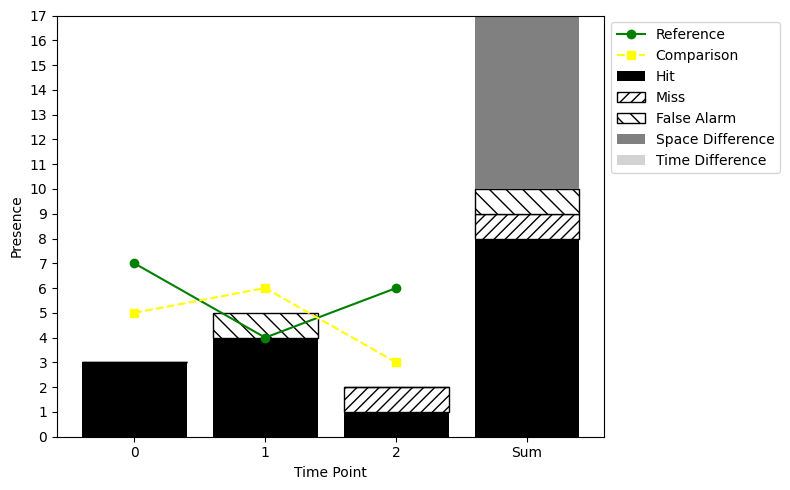

In [168]:
# 1) Per-timepoint component sums (t=0,1,2)
hits_tp   = h.sum(axis=1)
misses_tp = m.sum(axis=1)
false_tp  = f.sum(axis=1)

# 2) Full-extent (Sum) component sums
hits_sum   = hits_tp.sum()
misses_sum = misses_tp.sum()
false_sum  = false_tp.sum()
space_sum  = u.sum()
time_sum   = v.sum()

# 3) Assemble arrays for bars at positions [0,1,2,Sum]
hits_all   = np.append(hits_tp,hits_sum)
misses_all = np.append(misses_tp,misses_sum)
false_all  = np.append(false_tp,false_sum)
space_all  = np.array([0, 0, 0,space_sum])
time_all   = np.array([0, 0, 0,time_sum])

# 4) Reference & comparison series totals
ref_tp   = p_x.sum(axis=1)
comp_tp  = p_y.sum(axis=1)
ref_all  = np.append(ref_tp,ref_tp.sum())
comp_all = np.append(comp_tp,comp_tp.sum())

# 5) Plotting
categories = ['0', '1', '2', 'Sum']
x = np.arange(len(categories))

plt.figure(figsize=(8, 5))

# Stacked bars
plt.bar(x,
        hits_all,
        color='black',
        label='Hit'
        )
plt.bar(x,
        misses_all,
        bottom=hits_all,
        facecolor='white',
        edgecolor='black',
        hatch='///',
        label='Miss'
        )
plt.bar(x,
        false_all,
        bottom=hits_all+misses_all,
        facecolor='white',
        edgecolor='black',
        hatch='\\\\',
        label='False Alarm'
        )
plt.bar(x,
        space_all,
        bottom=hits_all+misses_all+false_all,
        color='gray',
        label='Space Difference'
        )
plt.bar(x,
        time_all,
        bottom=hits_all+misses_all+false_all+space_all,
        color='lightgray',
        label='Time Difference'
        )

# Overlay reference/comparison lines only for t=0,1,2
plt.plot(x[:num_time_points],
         ref_tp,color='green',
         linestyle='-',
         marker='o',
         label='Reference'
         )

plt.plot(x[:num_time_points],
         comp_tp,color='yellow',
         linestyle='--',
         marker='s',
         label='Comparison'
         )

# Axes, ticks, grid
plt.xlabel('Time Point')
plt.ylabel('Presence')
# plt.title('Presence Agreement Components Over Time')
plt.xticks(x, categories)
plt.ylim(0, 17)
plt.yticks(np.arange(0, 18, 1))

# Legend outside plot
plt.legend(loc='upper left',
           bbox_to_anchor=(1, 1)
           )

plt.tight_layout()
plt.show()

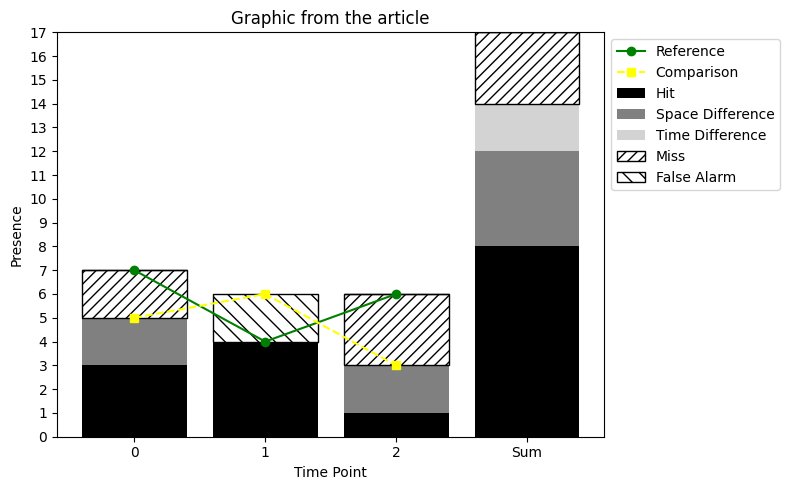

In [169]:
# Component values for each category: time points 0,1,2 and Sum
hits = np.array([3, 4, 1, 8])
space_diff = np.array([2, 0, 2, 4])
time_diff = np.array([0, 0, 0, 2])
misses = np.array([2, 0, 3, 3])
false_alarms = np.array([0, 2, 0, 0])

# Reference and comparison series sums
ref_sum = np.array([7, 4, 6, 17])
comp_sum = np.array([5, 6, 3, 14])

# Categories and positions
categories = ['0', '1', '2', 'Sum']
x = np.arange(len(categories))

plt.figure(figsize=(8, 5))

# Stacked bars
plt.bar(x, hits, color='black', label='Hit')
plt.bar(x, space_diff, bottom=hits, color='gray', label='Space Difference')
plt.bar(x, time_diff, bottom=hits + space_diff, color='lightgray', label='Time Difference')
plt.bar(x, misses, bottom=hits + space_diff + time_diff,
        facecolor='white', edgecolor='black', hatch='///', label='Miss')
plt.bar(x, false_alarms, bottom=hits + space_diff + time_diff + misses,
        facecolor='white', edgecolor='black', hatch='\\\\', label='False Alarm')

# x positions for the 3 actual time points
x_line = x[:3]

# Overlay series sums
plt.plot(x_line, ref_sum[:3], color='green', marker='o', label='Reference')
plt.plot(x_line, comp_sum[:3], color='yellow', linestyle='--', marker='s', label='Comparison')

# Axes and grid
plt.xlabel('Time Point')
plt.ylabel('Presence')
plt.title('Graphic from the article')
plt.ylim(0, 17)
plt.yticks(np.arange(0, 18, 1))
plt.xticks(x, categories)
# plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Legend outside plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### 6.2 Stacked Bar Chart: Gain & Loss Components
Next, we generate two side-by-side stacked bar charts—one for gains and one for losses—showing, at each interval:  
- shared change (gain hits or loss hits)  
- reference-only change (gain misses or loss misses)  
- comparison-only change (gain false alarms or loss false alarms)  
- spatial change differences  
- timing differences  

This highlights when and where increases or decreases align or diverge.

### 6.3 Composition of Full-Extent Change
Finally, we present a combined bar chart of total gains and total losses over the entire series (the “full extent”), with each component stacked. This summary plot shows overall change magnitude and the balance between agreement and disagreement across all intervals.

## 7. Exporting Results <a id="export"></a>

### 7.1 Save Metrics DataFrame to CSV/Excel  

### 7.2 Save Figures (PNG)  